# Learning GAN and WGAN for a synthetic 2-dimensional dataset

<br/><br/>
<a target="_blank" href="https://colab.research.google.com/github/generativemodelingmva/generativemodelingmva.github.io/blob/main/tp2324/tp2_generative_networks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<br/><br/>

This practical session contains
- "QUESTION" fields in the text, that you should answer
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebooks on Google Colab.

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

# If you don't want to bother with the device, stay on cpu:
# device = torch.device('cpu')

print(device)

cpu


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

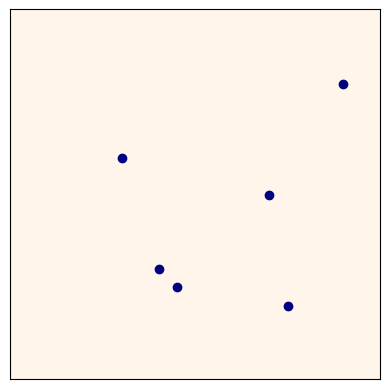

In [ ]:
d = 2   # dimension of the data points
n = 6   # number of data points

y = torch.zeros((n,d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2

y[1, 0] = 0.75
y[1, 1] = 0.8

y[2, 0] = 0.3
y[2, 1] = 0.4

y[3, 0] = 0.4
y[3, 1] = 0.7

y[4, 0] = 0.45
y[4, 1] = 0.75

y[5, 0] = 0.7
y[5, 1] = 0.5

nu = torch.ones(n, device=device)/n  # equal masses (nu is the empirical measure of the data)

# generate grid for plotting purpose
nr,nc = 256,256
extent = ((-0.5/nc, 1-0.5/nc, 1-0.5/nr, -0.5/nr))
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing='ij')
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr*nc,1),ym.reshape(nr*nc,1)),1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

In [ ]:
class Generator(torch.nn.Module):

    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n==0 else n_hid
            self.hidden.append(nn.Sequential(
            nn.Linear(n_in_t, n_hid),
            nn.ELU(1)
        ).to(device))

        self.out = nn.Sequential(
            nn.Linear(n_hid, n_out),
            nn.Sigmoid()
        ).to(device)

        self.apply(self._init_weights)


    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()


QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

torch.Size([100, 2])


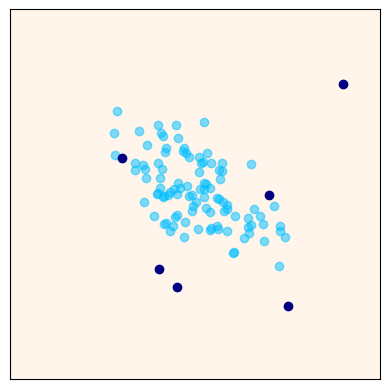

In [ ]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10    # dimension of the input noise
b = 100      # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)

### ... ###

z = torch.randn((b, n_in))
x = G(z)

print(x.shape)

xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr,nc)),cmap = 'Oranges', extent=extent) # background
plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

# Exercise 1: Learn a GAN

### Define Discriminator Architecture

QUESTION: Examine the layers and parameters of the following discriminative network.

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(Discriminator, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = nn.Sigmoid()(self.fc3(y))
    return y

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

[0/1000], 1.391471


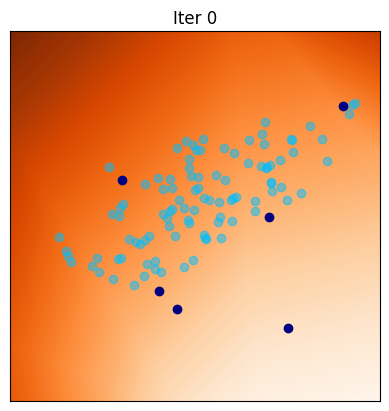

[100/1000], 1.313724


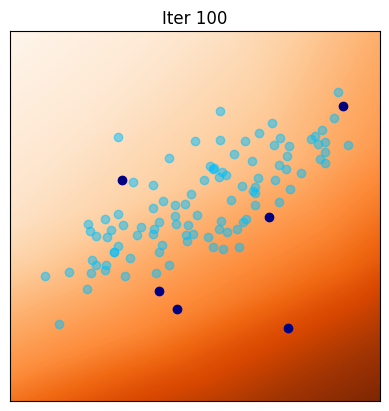

[200/1000], 1.039570


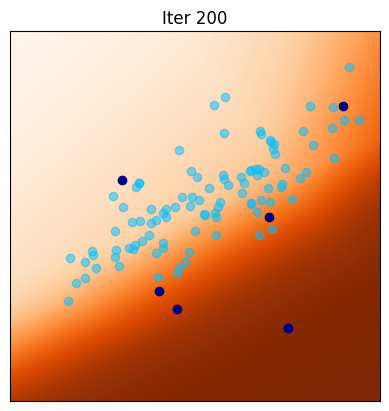

[300/1000], 0.968513


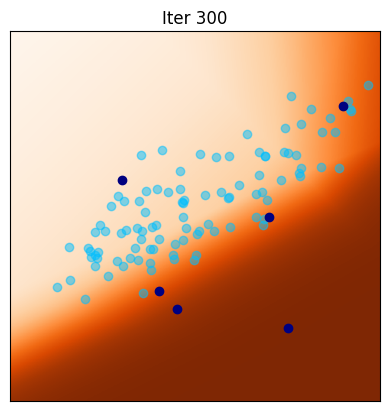

[400/1000], 0.873968


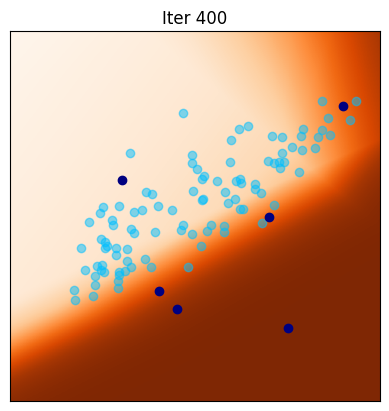

[500/1000], 0.874825


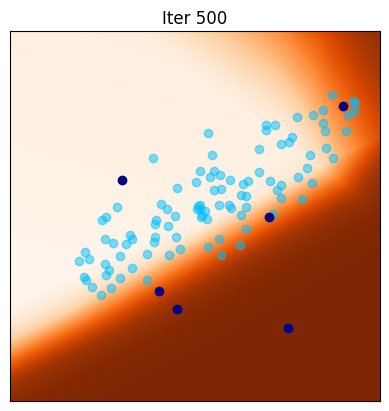

[600/1000], 0.727914


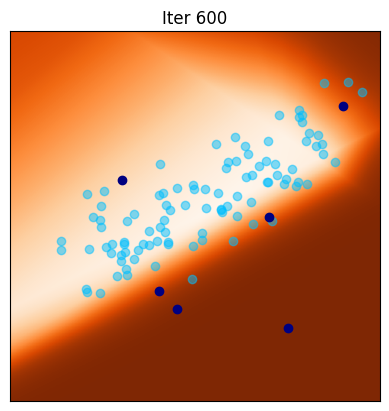

[700/1000], 0.571703


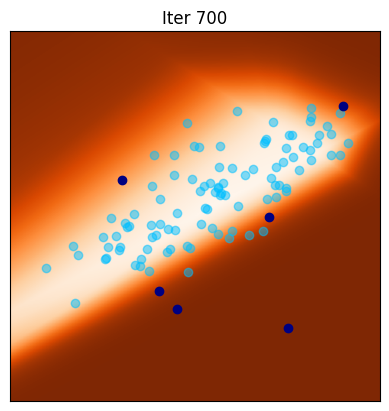

[800/1000], 0.497808


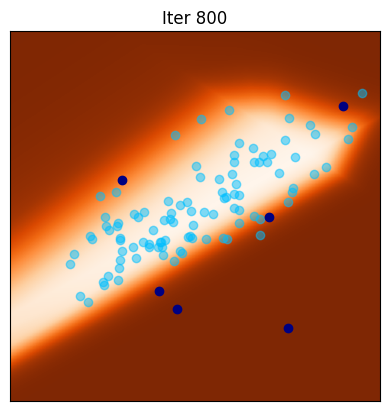

[900/1000], 0.510263


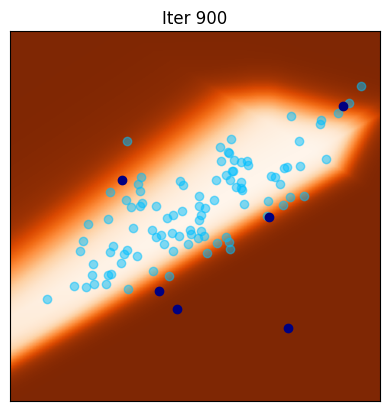

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()
    ### ... ###
    z = torch.randn((b, n_in))
    x = G(z)
    Dx = D(x.detach())
    Dy = D(y)
    Dloss = -(torch.mean(torch.log(Dy))  + torch.mean(torch.log(1-Dx)))
    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()


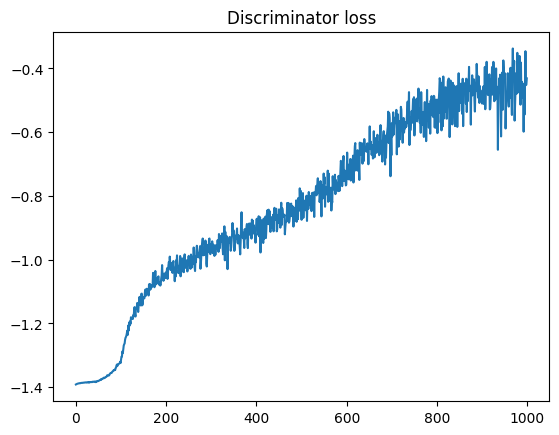

In [ ]:
### Plot the evolution of the discriminator loss ###

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title('Discriminator loss')
plt.show()

## Train both the Generator and Discriminator

[0/100] 	Loss_D: 0.6491	Loss_G: -2.1428


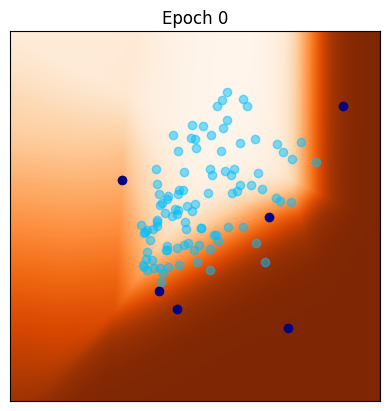

[1/100] 	Loss_D: 0.3792	Loss_G: -3.5917
[2/100] 	Loss_D: 0.2532	Loss_G: -5.2572
[3/100] 	Loss_D: 0.1959	Loss_G: -6.3744
[4/100] 	Loss_D: 0.1907	Loss_G: -7.4223
[5/100] 	Loss_D: 0.1549	Loss_G: -8.0911
[6/100] 	Loss_D: 0.1753	Loss_G: -8.1547
[7/100] 	Loss_D: 0.1537	Loss_G: -10.3874
[8/100] 	Loss_D: 0.1173	Loss_G: -11.3645
[9/100] 	Loss_D: 0.0292	Loss_G: -11.5693
[10/100] 	Loss_D: 0.0546	Loss_G: -13.1512


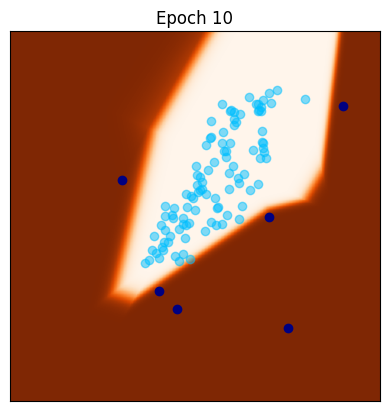

[11/100] 	Loss_D: 0.0194	Loss_G: -13.5019
[12/100] 	Loss_D: 0.0034	Loss_G: -13.9688
[13/100] 	Loss_D: 0.0135	Loss_G: -16.0170
[14/100] 	Loss_D: 0.0017	Loss_G: -15.8187
[15/100] 	Loss_D: 0.0011	Loss_G: -16.0157
[16/100] 	Loss_D: 0.0005	Loss_G: -16.1578
[17/100] 	Loss_D: 0.0022	Loss_G: -17.4060
[18/100] 	Loss_D: 0.0013	Loss_G: -17.6972
[19/100] 	Loss_D: 0.0001	Loss_G: -17.3035
[20/100] 	Loss_D: 0.0001	Loss_G: -17.9503


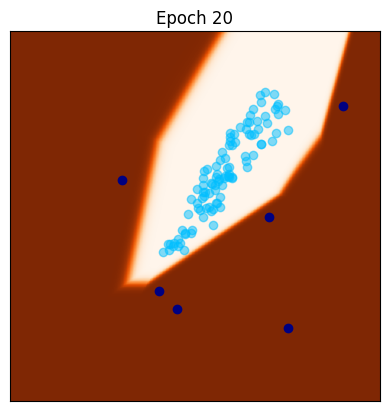

[21/100] 	Loss_D: 0.0001	Loss_G: -18.1154
[22/100] 	Loss_D: 0.0001	Loss_G: -17.8357
[23/100] 	Loss_D: 0.0000	Loss_G: -17.7830
[24/100] 	Loss_D: 0.0000	Loss_G: -17.6082
[25/100] 	Loss_D: 0.0000	Loss_G: -18.1765
[26/100] 	Loss_D: 0.0000	Loss_G: -17.8290
[27/100] 	Loss_D: 0.0001	Loss_G: -18.4734
[28/100] 	Loss_D: 0.0000	Loss_G: -17.6373
[29/100] 	Loss_D: 0.0000	Loss_G: -18.4535
[30/100] 	Loss_D: 0.0000	Loss_G: -18.2611


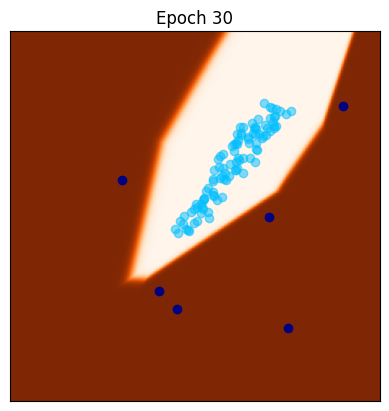

[31/100] 	Loss_D: 0.0000	Loss_G: -18.1021
[32/100] 	Loss_D: 0.0000	Loss_G: -18.6309
[33/100] 	Loss_D: 0.0000	Loss_G: -18.0654
[34/100] 	Loss_D: 0.0000	Loss_G: -18.8042
[35/100] 	Loss_D: 0.0000	Loss_G: -18.0103
[36/100] 	Loss_D: 0.0000	Loss_G: -17.9132
[37/100] 	Loss_D: 0.0001	Loss_G: -18.0678
[38/100] 	Loss_D: 0.0000	Loss_G: -18.7496
[39/100] 	Loss_D: 0.0000	Loss_G: -18.5822
[40/100] 	Loss_D: 0.0000	Loss_G: -18.5269


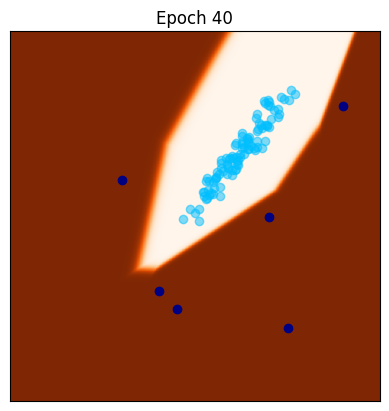

[41/100] 	Loss_D: 0.0000	Loss_G: -18.7478
[42/100] 	Loss_D: 0.0000	Loss_G: -18.6758
[43/100] 	Loss_D: 0.0000	Loss_G: -19.0592
[44/100] 	Loss_D: 0.0000	Loss_G: -19.3776
[45/100] 	Loss_D: 0.0000	Loss_G: -18.8007
[46/100] 	Loss_D: 0.0000	Loss_G: -19.9355
[47/100] 	Loss_D: 0.0000	Loss_G: -19.8306
[48/100] 	Loss_D: 0.0000	Loss_G: -19.8840
[49/100] 	Loss_D: 0.0000	Loss_G: -20.0421
[50/100] 	Loss_D: 0.0000	Loss_G: -18.8956


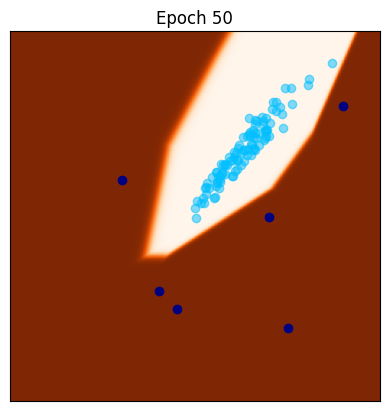

[51/100] 	Loss_D: 0.0000	Loss_G: -19.8065
[52/100] 	Loss_D: 0.0000	Loss_G: -18.6704
[53/100] 	Loss_D: 0.0000	Loss_G: -19.1690
[54/100] 	Loss_D: 0.0000	Loss_G: -19.4390
[55/100] 	Loss_D: 0.0000	Loss_G: -19.9106
[56/100] 	Loss_D: 0.0000	Loss_G: -19.5306
[57/100] 	Loss_D: 0.0000	Loss_G: -19.1760
[58/100] 	Loss_D: 0.0000	Loss_G: -18.9733
[59/100] 	Loss_D: 0.0000	Loss_G: -19.0925
[60/100] 	Loss_D: 0.0000	Loss_G: -18.5109


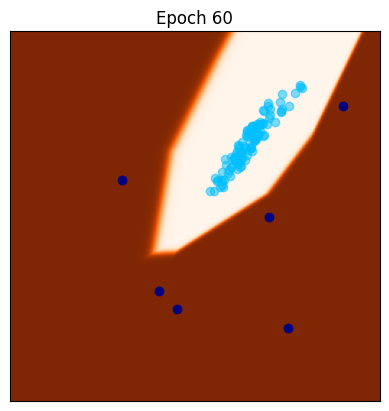

[61/100] 	Loss_D: 0.0000	Loss_G: -18.7388
[62/100] 	Loss_D: 0.0000	Loss_G: -19.0575
[63/100] 	Loss_D: 0.0000	Loss_G: -18.9011
[64/100] 	Loss_D: 0.0000	Loss_G: -19.1884
[65/100] 	Loss_D: 0.0000	Loss_G: -19.0810
[66/100] 	Loss_D: 0.0000	Loss_G: -19.3461
[67/100] 	Loss_D: 0.0000	Loss_G: -19.4275
[68/100] 	Loss_D: 0.0000	Loss_G: -19.4638
[69/100] 	Loss_D: 0.0000	Loss_G: -19.8338
[70/100] 	Loss_D: 0.0000	Loss_G: -19.7845


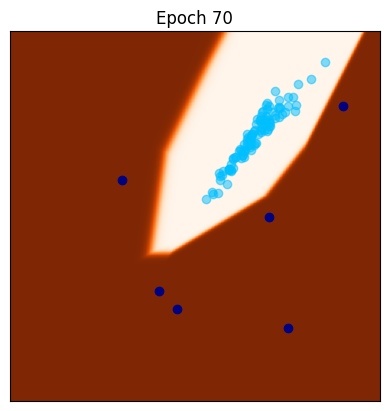

[71/100] 	Loss_D: 0.0000	Loss_G: -19.6573
[72/100] 	Loss_D: 0.0000	Loss_G: -19.7362
[73/100] 	Loss_D: 0.0000	Loss_G: -20.1989
[74/100] 	Loss_D: 0.0000	Loss_G: -20.0230
[75/100] 	Loss_D: 0.0000	Loss_G: -19.6998
[76/100] 	Loss_D: 0.0000	Loss_G: -20.3106
[77/100] 	Loss_D: 0.0000	Loss_G: -20.0673
[78/100] 	Loss_D: 0.0000	Loss_G: -20.0514
[79/100] 	Loss_D: 0.0000	Loss_G: -19.7235
[80/100] 	Loss_D: 0.0000	Loss_G: -19.7157


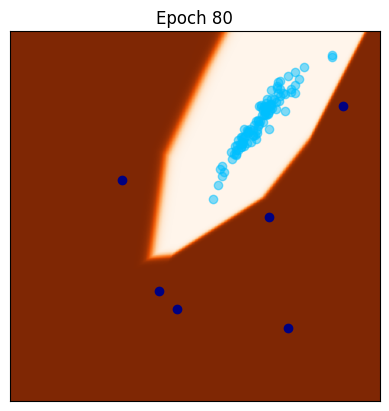

[81/100] 	Loss_D: 0.0000	Loss_G: -19.4863
[82/100] 	Loss_D: 0.0000	Loss_G: -19.4353
[83/100] 	Loss_D: 0.0000	Loss_G: -19.5029
[84/100] 	Loss_D: 0.0000	Loss_G: -19.6492
[85/100] 	Loss_D: 0.0000	Loss_G: -18.7080
[86/100] 	Loss_D: 0.0000	Loss_G: -19.1499
[87/100] 	Loss_D: 0.0000	Loss_G: -19.9249
[88/100] 	Loss_D: 0.0000	Loss_G: -20.0880
[89/100] 	Loss_D: 0.0000	Loss_G: -20.0849
[90/100] 	Loss_D: 0.0000	Loss_G: -20.0245


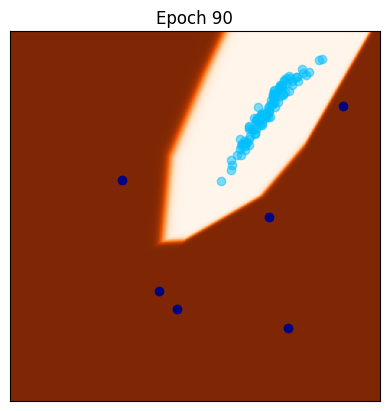

[91/100] 	Loss_D: 0.0000	Loss_G: -20.1309
[92/100] 	Loss_D: 0.0000	Loss_G: -20.0344
[93/100] 	Loss_D: 0.0000	Loss_G: -19.8663
[94/100] 	Loss_D: 0.0000	Loss_G: -19.2888
[95/100] 	Loss_D: 0.0000	Loss_G: -20.6914
[96/100] 	Loss_D: 0.0000	Loss_G: -20.3931
[97/100] 	Loss_D: 0.0000	Loss_G: -20.4704
[98/100] 	Loss_D: 0.0000	Loss_G: -20.4672
[99/100] 	Loss_D: 0.0000	Loss_G: -21.7177


<All keys matched successfully>

In [ ]:
lr = 0.0002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
### ... ###
G = Generator(n_in=n_in, n_out=d, n_hid=7, nlayers=3, device=device) #It was initially with 100 hidden layers, but it was apparently too much
D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))
optimG = optim.Adam(G.parameters(), lr=lr)
Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):
    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0,niterD):
        ### ... ###
        optimD.zero_grad()
        ### ... ###
        z = torch.randn((b, n_in))
        x = G(z)
        Dx = D(x.detach()) #Mettre un .detach() est très important pour le calcul des gradients lors du backward
        Dy = D(y) #Known points
        Dloss = -(torch.mean(torch.log(Dy))  + torch.mean(torch.log(1-Dx)))
        Dloss.backward()
        optimD.step()


    # ############################
    # ### Train generator (niterG iterations)
    # ############################
    for iter in range(0,niterG):
        ### ... ###
        optimG.zero_grad()
        z = torch.randn((b, n_in))
        x = G(z)
        Dx = D(x) #Pas de .detach() ici
        Gloss = torch.mean(torch.log(Dx))
        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=7, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

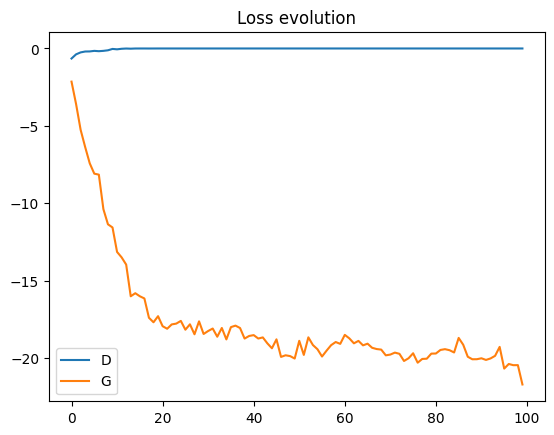

In [ ]:
### Plot the evolution of the discriminator and generator losses ###

plt.figure(dpi=100)
plt.plot(Dlosses,label='D')
plt.plot(Glosses,label='G')
plt.title('Loss evolution')
plt.legend()
plt.show()

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then? We are observing mode collapse

[0/100] 	Loss_D: 0.0000	Loss_G: -0.7617


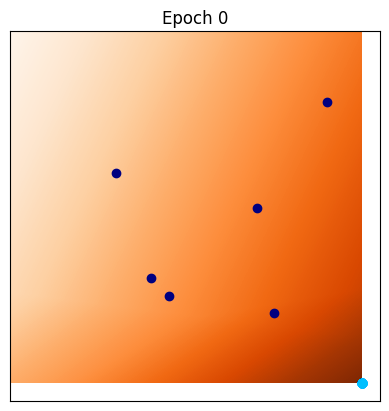

[1/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[2/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[3/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[4/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[5/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[6/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[7/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[8/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[9/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[10/100] 	Loss_D: 0.0000	Loss_G: -0.7617


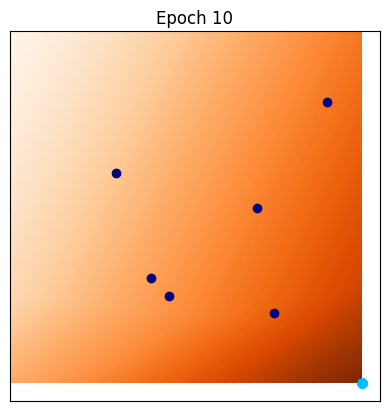

[11/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[12/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[13/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[14/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[15/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[16/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[17/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[18/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[19/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[20/100] 	Loss_D: 0.0000	Loss_G: -0.7617


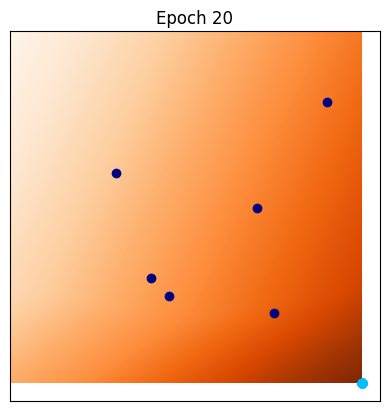

[21/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[22/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[23/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[24/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[25/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[26/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[27/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[28/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[29/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[30/100] 	Loss_D: 0.0000	Loss_G: -0.7617


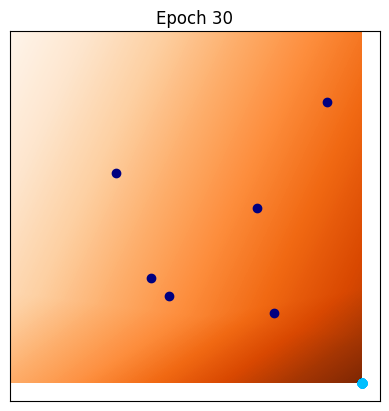

[31/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[32/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[33/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[34/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[35/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[36/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[37/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[38/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[39/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[40/100] 	Loss_D: 0.0000	Loss_G: -0.7617


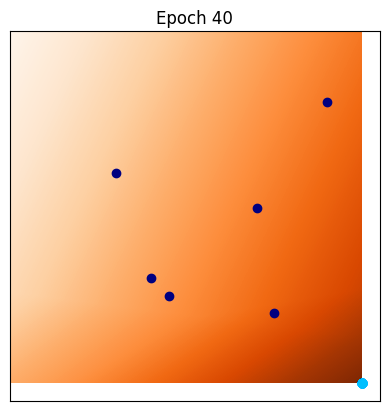

[41/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[42/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[43/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[44/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[45/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[46/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[47/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[48/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[49/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[50/100] 	Loss_D: 0.0000	Loss_G: -0.7617


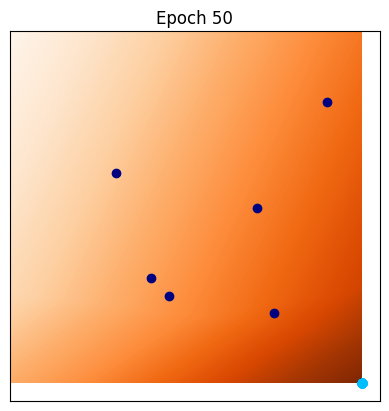

[51/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[52/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[53/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[54/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[55/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[56/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[57/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[58/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[59/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[60/100] 	Loss_D: 0.0000	Loss_G: -0.7617


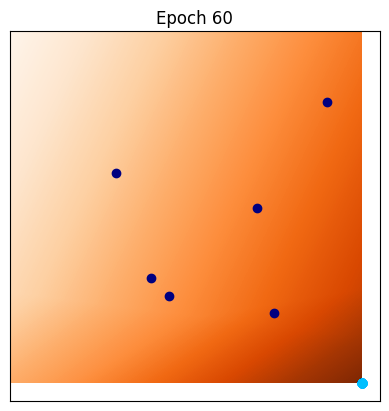

[61/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[62/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[63/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[64/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[65/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[66/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[67/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[68/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[69/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[70/100] 	Loss_D: 0.0000	Loss_G: -0.7617


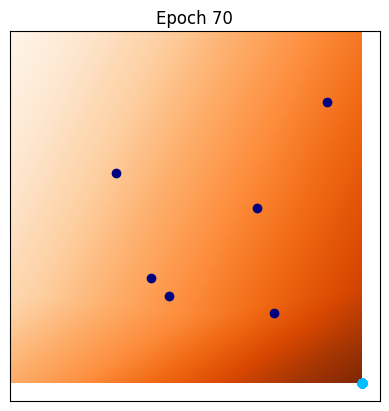

[71/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[72/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[73/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[74/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[75/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[76/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[77/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[78/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[79/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[80/100] 	Loss_D: 0.0000	Loss_G: -0.7617


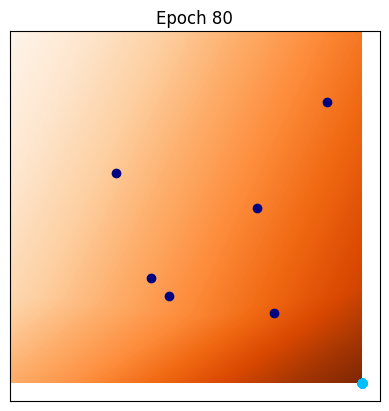

[81/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[82/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[83/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[84/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[85/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[86/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[87/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[88/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[89/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[90/100] 	Loss_D: 0.0000	Loss_G: -0.7617


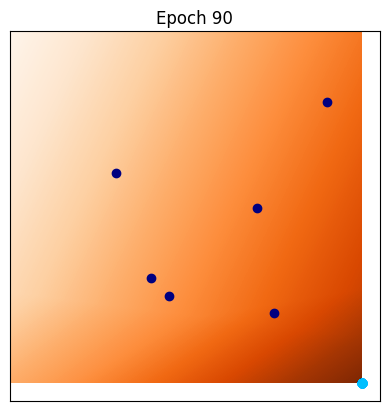

[91/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[92/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[93/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[94/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[95/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[96/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[97/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[98/100] 	Loss_D: 0.0000	Loss_G: -0.7617
[99/100] 	Loss_D: 0.0000	Loss_G: -0.7617


<All keys matched successfully>

In [ ]:
lr = 0.2   # learning rate for generator

## parameters for training
n_epochs = 100
niterG=100

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
### ... ###
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device) #Discriminator fixed, whithout any training
optimG = optim.Adam(G.parameters(), lr=lr)
Glosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):
    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0,niterG):
        ### ... ###

        optimG.zero_grad()
        z = torch.randn((b, n_in))
        x = G(z)
        Dx = D(x)
        Gloss = torch.mean(torch.log(1 - Dx))
        Gloss.backward()
        optimG.step()

    # Output training stats
    print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
      % (epoch, n_epochs, Dloss.item(), Gloss.item()))
    Glosses.append(Gloss.item())


    if(epoch % iter_display == 0):
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        z = torch.randn(b, 1, n_in, device=device) #noise
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Epoch '+str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

<br/><br/><br/><br/>

# Exercise 2: Learn a WGAN with 1-Lipschitz discriminator

Goal is to have a more stable GAN with WGAN

In [ ]:
# Discriminator adapted for WGAN-GP
#  Remark the absence of final sigmoid function in this case.

class DWGAN(nn.Module):
  def __init__(self, n_in, n_hid=10):
    super(DWGAN, self).__init__()

    self.n_hid = n_hid
    self.n_in = n_in

    self.fc1 = nn.Linear(n_in, n_hid)
    self.fc2 = nn.Linear(n_hid, n_hid)
    self.fc3 = nn.Linear(n_hid, 1)

  def forward(self, x):
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
    y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
    y = self.fc3(y)
    return y

## Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=30, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD=1000

clip_value = .1

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):

    ### UPDATE OF D ###
    ### ... (optim of D) ... ###
    optimD.zero_grad()
    z = torch.randn((b, n_in))
    x = G(z) #The generator is fixed
    Dx = D(x.detach())
    Dy = D(y) #Known points
    Dloss = -(torch.mean(Dy) - torch.mean(Dx))
    Dloss.backward()
    optimD.step()

    ### ... (weight clipping step) ... ###
    for p in D.parameters():
      p.data.clamp_(-clip_value, clip_value)

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if(iter%iter_display == 0):
        print('[%d/%d], %f' % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = 'Iter '+str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
        plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)

NameError: name 'lr' is not defined

QUESTION: Now, train both the generator and discriminator with the WGAN loss and weight clipping. Rend le discriminateur trop lisse...

In [ ]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

clip_value = .1
iter_display = 10

### ... ###
#  (adapt the loop written for GAN training above)

for epoch in range(n_epochs):

  ############################
  ### Train discriminator (niterD iterations)
  ############################
  for iter in range(0,niterD):
      ### ... ###
      optimD.zero_grad()
      ### ... ###
      z = torch.randn((b, n_in))
      x = G(z)
      Dx = D(x.detach())
      Dy = D(y) #Known points
      Dloss = -(torch.mean(Dy) - torch.mean(Dx))
      Dloss.backward()
      optimD.step()

  ### ... (weight clipping step) ... ###
  for p in D.parameters():
      p.data.clamp_(-clip_value, clip_value)

  ############################
  ### Train generator (niterG iterations)
  ############################
  for iter in range(0,niterG):
      ### ... ###
      optimG.zero_grad()
      z = torch.randn((b, n_in))
      x = G(z)
      Dx = D(x)
      Gloss = -torch.mean(Dx)
      Gloss.backward()
      optimG.step()


  # Output training stats
  print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
    % (epoch, n_epochs, Dloss.item(), Gloss.item()))
  Glosses.append(Gloss.item())


  if(epoch % iter_display == 0):
      Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
      z = torch.randn(b, 1, n_in, device=device) #noise
      x = G(z)
      xd = x.detach().squeeze(1)
      strtitle = 'Epoch '+str(epoch)
      fig = plt.figure(dpi=100)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
      plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
      plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
      plt.title(strtitle)
      plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

NameError: name 'lrdisc' is not defined

## Estimate the Lipschitz constant of the discriminator

QUESTION: Implement a function computing an estimation of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

Use this function to examine the Lipschitz constant of the final discriminator obtained with WGAN-WC.

In [ ]:
def lipconstant(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device) #We take samples
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()

    # Calculate discriminator on interpolated examples
    Di = D(interp)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size())
    gradients = torch.autograd.grad(outputs = Di, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0]
    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim = 1))

    # Return gradient penalty
    return torch.mean(gradients_norm)

#### (lip constant of the current D) ###

## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of $D$ on points that are interpolated between $x$ and $y$.

In [ ]:
def gradient_penalty(D,x,y):
    # Calculate interpolation
    b = x.shape[0]
    n = y.shape[0]
    alpha = torch.rand((b,n,1),device=device)
    interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    interp.requires_grad_()
    #### ... ####
    D_interp = D(interp)

    gradout = torch.ones(D_interp.size())
    gradients = torch.autograd.grad(outputs = D_interp, inputs = interp, grad_outputs = gradout, create_graph = True, retain_graph = True)[0]
    gradient_norm = torch.empty((gradients.size()[0]))
    for i in range(len(gradients)):
      gradient_norm[i] = (torch.norm(gradients[i]) - 1)**2
    # Return gradient penalty
    return torch.mean(gradient_norm)

## Train the WGAN-GP discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\leq 1$.

[0/1000], 0.749047


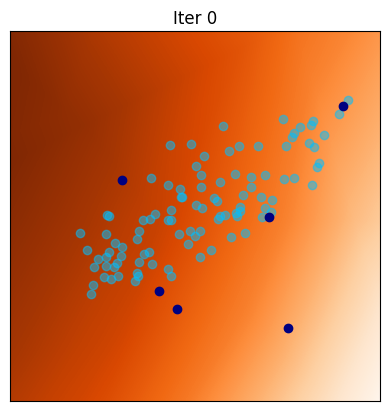

[100/1000], 0.097595


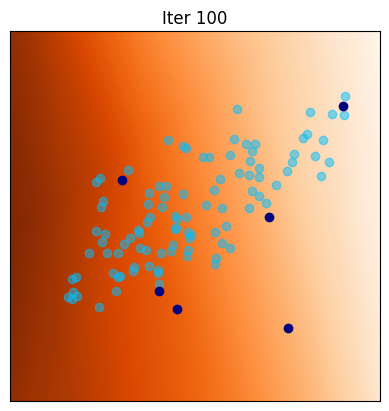

[200/1000], 0.016199


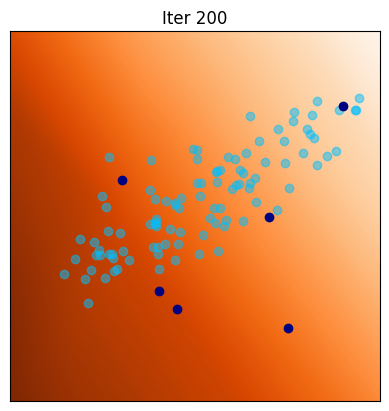

[300/1000], -0.096912


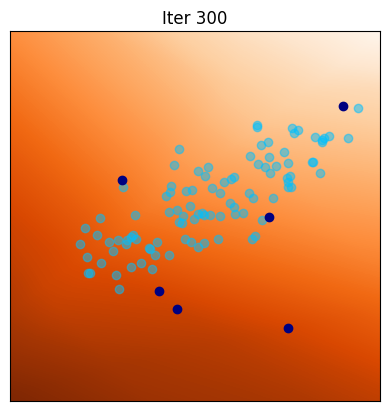

[400/1000], -0.116510


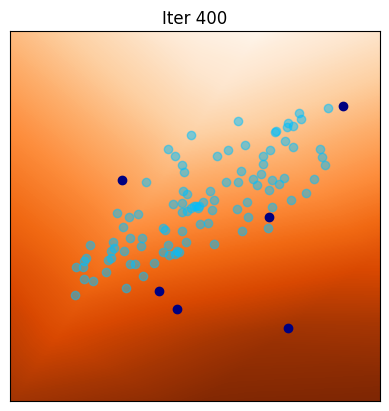

[500/1000], -0.123743


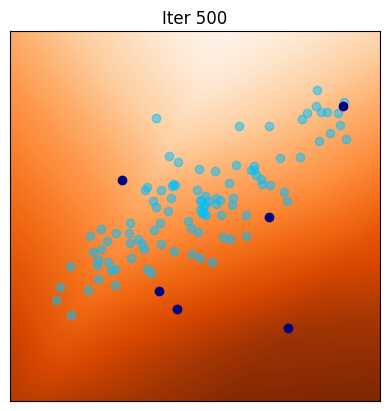

[600/1000], -0.141938


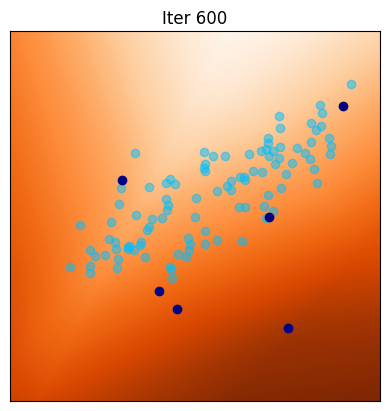

[700/1000], -0.126270


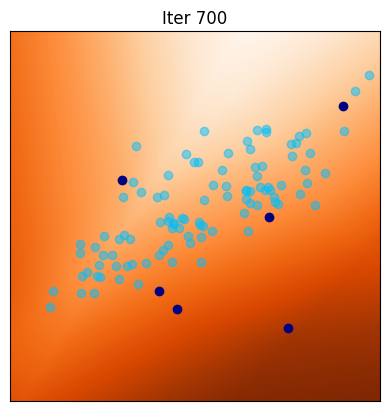

[800/1000], -0.123235


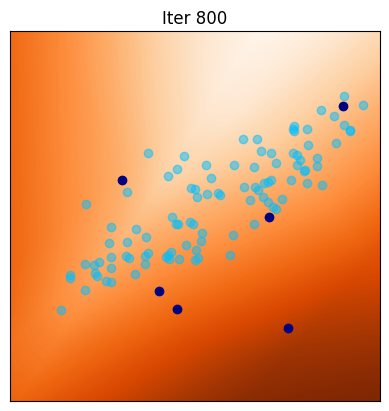

[900/1000], -0.127091


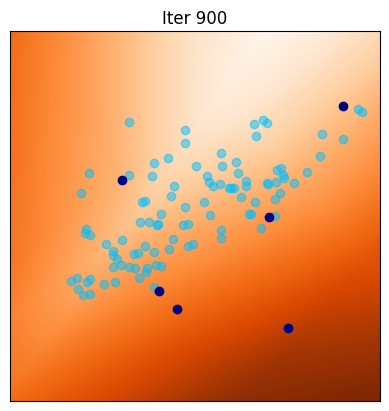

Final estimated Lipschitz constant =  1.0516726970672607


In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Reinitialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = DWGAN(n_in=d, n_hid=50).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 1
niterD=1000

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0,niterD):
  # (adapt the loop written for WGAN-WC)
  optimD.zero_grad()
  z = torch.randn((b, n_in))
  x = G(z)
  Dx = D(x.detach())
  Dy = D(y) #Known
  Dloss = -(torch.mean(Dy) - torch.mean(Dx) - gpw*gradient_penalty(D,x,y))
  Dloss.backward()
  optimD.step()


  ### SAVE LOSS ###
  Dlosst = Dloss.item()
  Dlosses.append(-Dlosst)
  if(iter%iter_display == 0):
      print('[%d/%d], %f' % (iter, niterD, Dlosst))
      Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
      x = G(z)
      xd = x.detach().squeeze(1)
      strtitle = 'Iter '+str(iter)
      fig = plt.figure(dpi=100)
      plt.xticks([])

      plt.yticks([])
      plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
      plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
      plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
      plt.title(strtitle)
      plt.show()
# Save final generator for later use
wganwc = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wganwc.load_state_dict(G.state_dict())
print('Final estimated Lipschitz constant = ',lipconstant(D,x,y).item())

## Train both the Generator and Discriminator

QUESTION: Learn both generator and discriminator with the gradient penalty term

[0/100] 	Loss_D: -0.1902	Loss_G: 0.0183


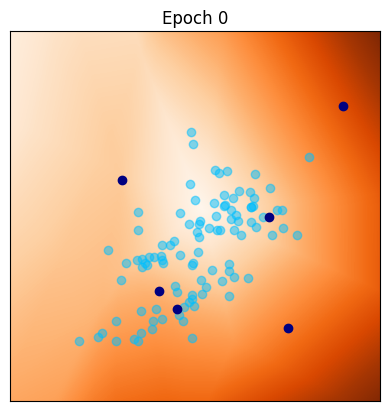

[1/100] 	Loss_D: -0.1633	Loss_G: 0.1326
[2/100] 	Loss_D: -0.1309	Loss_G: 0.0521
[3/100] 	Loss_D: -0.1243	Loss_G: -0.1264
[4/100] 	Loss_D: -0.0803	Loss_G: -0.0292
[5/100] 	Loss_D: -0.1384	Loss_G: -0.2051


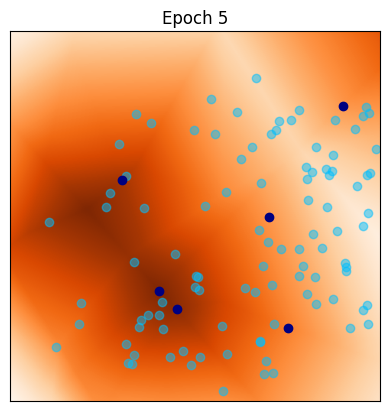

[6/100] 	Loss_D: -0.1448	Loss_G: -0.4959
[7/100] 	Loss_D: -0.0920	Loss_G: -0.7715
[8/100] 	Loss_D: -0.1000	Loss_G: -1.1284
[9/100] 	Loss_D: -0.0860	Loss_G: -1.7731
[10/100] 	Loss_D: -0.1078	Loss_G: -2.5359


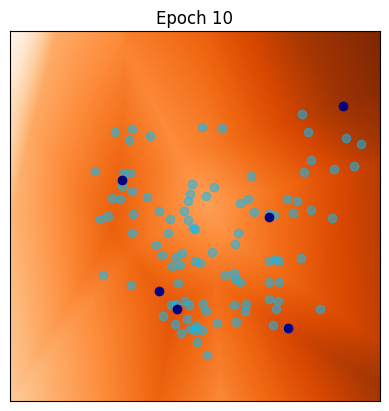

[11/100] 	Loss_D: -0.1103	Loss_G: -3.4731
[12/100] 	Loss_D: -0.0682	Loss_G: -3.7111
[13/100] 	Loss_D: -0.0548	Loss_G: -4.2771
[14/100] 	Loss_D: -0.0756	Loss_G: -4.5723
[15/100] 	Loss_D: -0.1054	Loss_G: -5.0266


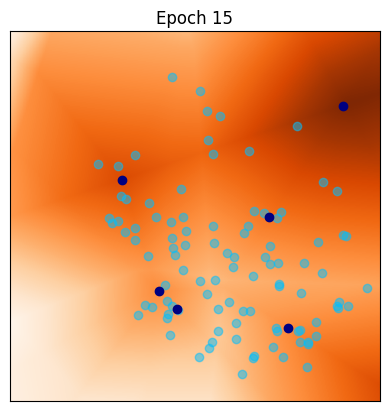

[16/100] 	Loss_D: -0.1076	Loss_G: -5.3771
[17/100] 	Loss_D: -0.0971	Loss_G: -5.2795
[18/100] 	Loss_D: -0.1276	Loss_G: -5.9345
[19/100] 	Loss_D: -0.1239	Loss_G: -6.1278
[20/100] 	Loss_D: -0.0865	Loss_G: -6.3805


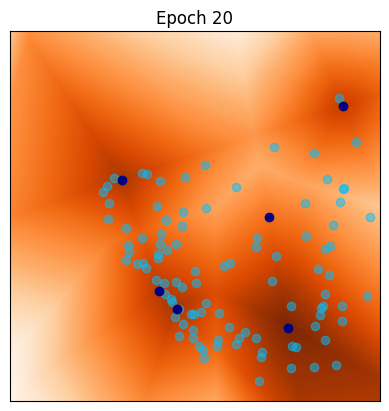

[21/100] 	Loss_D: -0.0981	Loss_G: -7.4712
[22/100] 	Loss_D: -0.1011	Loss_G: -7.7812
[23/100] 	Loss_D: -0.0789	Loss_G: -8.3729
[24/100] 	Loss_D: -0.0960	Loss_G: -8.6456
[25/100] 	Loss_D: -0.0952	Loss_G: -8.3129


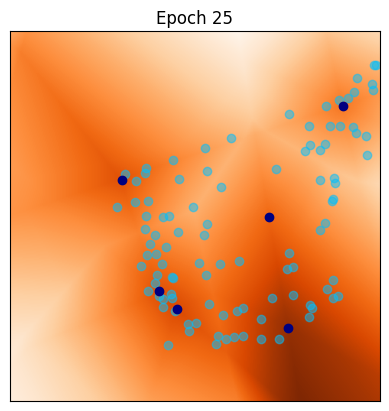

[26/100] 	Loss_D: -0.0784	Loss_G: -8.6654
[27/100] 	Loss_D: -0.0795	Loss_G: -9.3852
[28/100] 	Loss_D: -0.0899	Loss_G: -10.3601
[29/100] 	Loss_D: -0.0856	Loss_G: -11.5698
[30/100] 	Loss_D: -0.0872	Loss_G: -12.5608


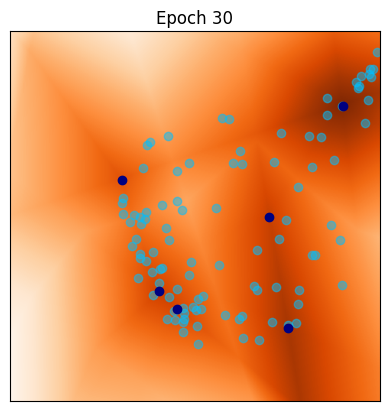

[31/100] 	Loss_D: -0.1047	Loss_G: -13.2302
[32/100] 	Loss_D: -0.0841	Loss_G: -13.5797
[33/100] 	Loss_D: -0.0878	Loss_G: -14.3583
[34/100] 	Loss_D: -0.0822	Loss_G: -15.6686
[35/100] 	Loss_D: -0.0824	Loss_G: -17.1715


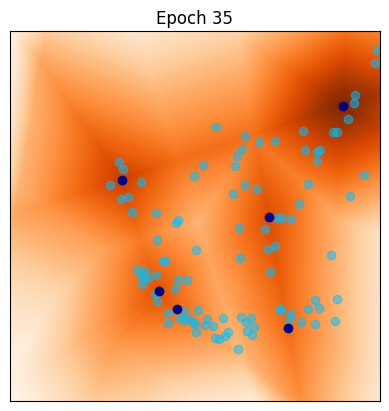

[36/100] 	Loss_D: -0.0797	Loss_G: -18.7205
[37/100] 	Loss_D: -0.0711	Loss_G: -19.5701
[38/100] 	Loss_D: -0.0856	Loss_G: -20.0991
[39/100] 	Loss_D: -0.0735	Loss_G: -20.6676
[40/100] 	Loss_D: -0.0794	Loss_G: -21.5381


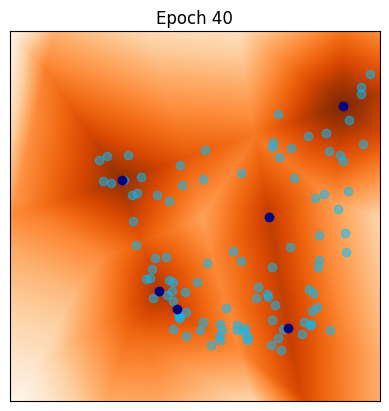

[41/100] 	Loss_D: -0.0740	Loss_G: -22.8062
[42/100] 	Loss_D: -0.0675	Loss_G: -23.9779
[43/100] 	Loss_D: -0.0670	Loss_G: -24.7381
[44/100] 	Loss_D: -0.0726	Loss_G: -25.7846
[45/100] 	Loss_D: -0.0717	Loss_G: -26.8155


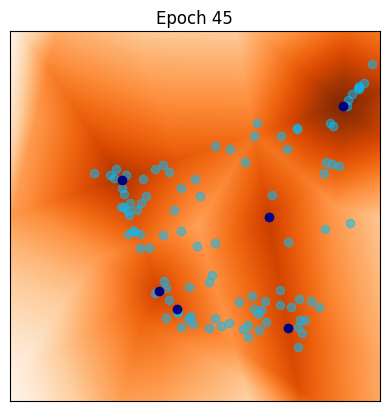

[46/100] 	Loss_D: -0.0738	Loss_G: -27.9906
[47/100] 	Loss_D: -0.0687	Loss_G: -29.3080
[48/100] 	Loss_D: -0.0646	Loss_G: -30.0881
[49/100] 	Loss_D: -0.0706	Loss_G: -30.4219
[50/100] 	Loss_D: -0.0674	Loss_G: -30.7704


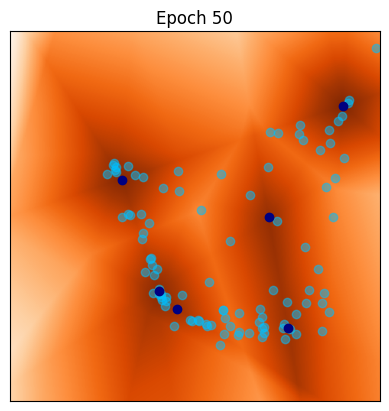

[51/100] 	Loss_D: -0.0591	Loss_G: -31.7684
[52/100] 	Loss_D: -0.0691	Loss_G: -32.8609
[53/100] 	Loss_D: -0.0591	Loss_G: -33.7702
[54/100] 	Loss_D: -0.0657	Loss_G: -34.2000
[55/100] 	Loss_D: -0.0537	Loss_G: -34.9040


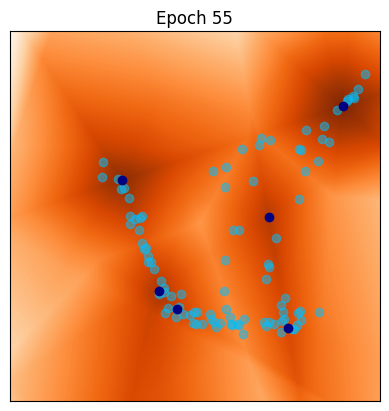

[56/100] 	Loss_D: -0.0626	Loss_G: -35.6070
[57/100] 	Loss_D: -0.0646	Loss_G: -36.5374
[58/100] 	Loss_D: -0.0657	Loss_G: -36.9887
[59/100] 	Loss_D: -0.0531	Loss_G: -37.8138
[60/100] 	Loss_D: -0.0680	Loss_G: -38.1574


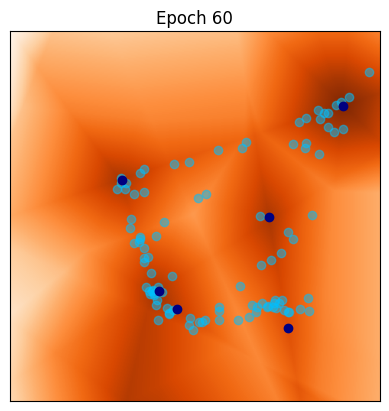

[61/100] 	Loss_D: -0.0572	Loss_G: -40.0202
[62/100] 	Loss_D: -0.0532	Loss_G: -40.6615
[63/100] 	Loss_D: -0.0694	Loss_G: -37.7519
[64/100] 	Loss_D: -0.0655	Loss_G: -37.0208
[65/100] 	Loss_D: -0.0627	Loss_G: -39.5462


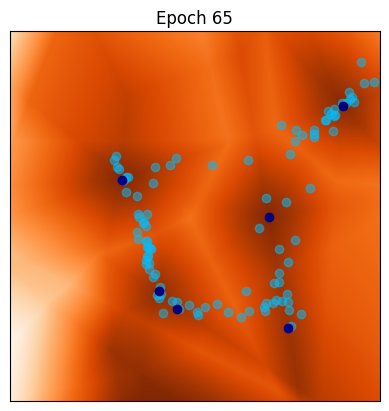

[66/100] 	Loss_D: -0.0565	Loss_G: -41.9516
[67/100] 	Loss_D: -0.0572	Loss_G: -41.9836
[68/100] 	Loss_D: -0.0532	Loss_G: -39.6009
[69/100] 	Loss_D: -0.0752	Loss_G: -39.5592
[70/100] 	Loss_D: -0.0775	Loss_G: -37.9134


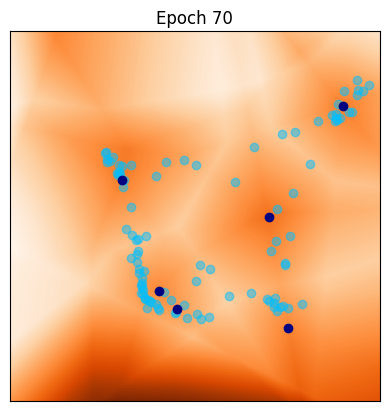

[71/100] 	Loss_D: -0.0647	Loss_G: -39.5961
[72/100] 	Loss_D: -0.0620	Loss_G: -43.3693
[73/100] 	Loss_D: -0.0635	Loss_G: -43.4150
[74/100] 	Loss_D: -0.0499	Loss_G: -40.7216
[75/100] 	Loss_D: -0.0823	Loss_G: -41.6091


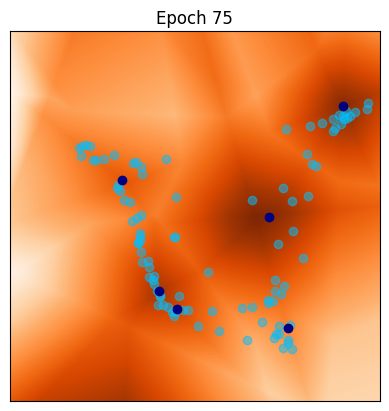

[76/100] 	Loss_D: -0.0547	Loss_G: -45.7354
[77/100] 	Loss_D: -0.0732	Loss_G: -44.5387
[78/100] 	Loss_D: -0.0765	Loss_G: -45.2044
[79/100] 	Loss_D: -0.0643	Loss_G: -47.8333
[80/100] 	Loss_D: -0.0583	Loss_G: -49.2505


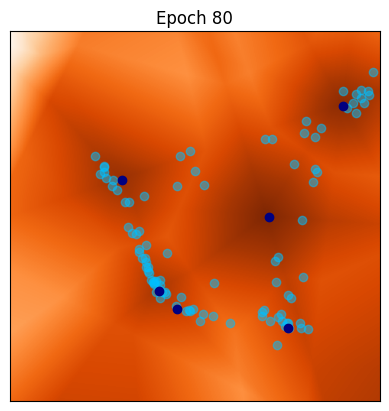

[81/100] 	Loss_D: -0.0584	Loss_G: -49.7397
[82/100] 	Loss_D: -0.0544	Loss_G: -52.0653
[83/100] 	Loss_D: -0.0738	Loss_G: -55.4342
[84/100] 	Loss_D: -0.0562	Loss_G: -57.8863
[85/100] 	Loss_D: -0.0732	Loss_G: -57.3734


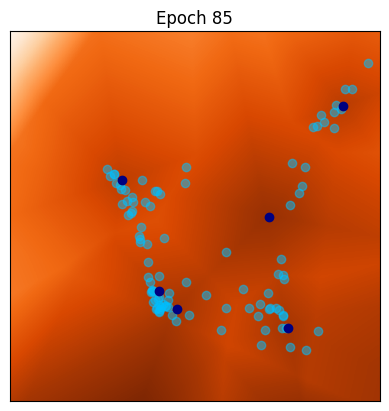

[86/100] 	Loss_D: -0.0536	Loss_G: -57.8306
[87/100] 	Loss_D: -0.0715	Loss_G: -59.2018
[88/100] 	Loss_D: -0.0668	Loss_G: -60.6655
[89/100] 	Loss_D: -0.0724	Loss_G: -59.6651
[90/100] 	Loss_D: -0.0746	Loss_G: -59.0495


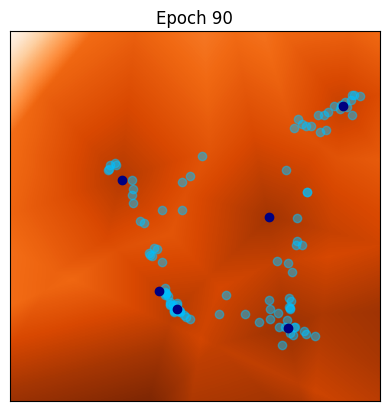

[91/100] 	Loss_D: -0.0660	Loss_G: -60.2634
[92/100] 	Loss_D: -0.0637	Loss_G: -62.3245
[93/100] 	Loss_D: -0.0544	Loss_G: -61.0788
[94/100] 	Loss_D: -0.0635	Loss_G: -60.8167
[95/100] 	Loss_D: -0.0688	Loss_G: -61.1151


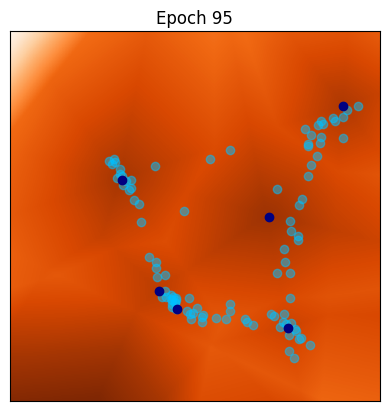

[96/100] 	Loss_D: -0.0648	Loss_G: -61.7761
[97/100] 	Loss_D: -0.0581	Loss_G: -63.3527
[98/100] 	Loss_D: -0.0668	Loss_G: -61.8999
[99/100] 	Loss_D: -0.0605	Loss_G: -68.4802
Final estimated Lipschitz constant =  1.0330493450164795


<All keys matched successfully>

In [ ]:
lr = 0.002   # learning rate for generator

# parameters for training
n_epochs = 100
niterD=1000
niterG=10

lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
gpw = 1

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = DWGAN(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 5
for epoch in range(n_epochs):
  for iter in range(0,niterD):
    #### ... ###
    # (adapt the loop written for WGAN-WC)
    optimD.zero_grad()
    z = torch.randn((b, n_in))
    x = G(z)
    Dx = D(x.detach())
    Dy = D(y) # K n o w n
    Dloss = -(torch.mean(Dy) - torch.mean(Dx) - gpw*gradient_penalty(D,x,y))
    Dloss.backward()
    optimD.step()

  # ############################
  # ### Train generator (niterG iterations)
  # ############################

  for iter in range(0,niterG):
    optimG.zero_grad()
    z = torch.randn((b, n_in))
    x = G(z)
    Dx = D(x)
    Gloss = - torch.mean(Dx)
    Gloss.backward()
    optimG.step()

# Output training stats
  print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
    % (epoch, n_epochs, Dloss.item(), Gloss.item()))
  Glosses.append(Gloss.item())
  if(epoch % iter_display == 0):
      Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr,nc)
      z = torch.randn(b, 1, n_in, device=device) #noise
      x = G(z)
      xd = x.detach().squeeze(1)
      strtitle = 'Epoch '+str(epoch)
      fig = plt.figure(dpi=100)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(Dxgrid,cmap = 'Oranges', extent=extent)  # discriminator
      plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
      plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
      plt.title(strtitle)
      plt.show()

print('Final estimated Lipschitz constant = ',lipconstant(D,x,y).item())
# Save final generator for later use
wganwc = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wganwc.load_state_dict(G.state_dict())

<br/><br/><br/><br/>

# Exercise 3: Learn a semi-discrete WGAN (with c-transform)

In this exercise, we will learn a WGAN with semi-discrete OT for the cost $c(x,y) = \|x-y\|^p$.

QUESTION: Implement the c-transform parameterized by the vector $v = (\psi(y_j))_{1 \leq j \leq n}$ ($\psi$ is the dual variable of the optimal transport cost).

The c-transform should apply to a batch of points x.

In [ ]:
# Recall the shape of the tensors at play:
#   x   (b , d)
#   y   (n,  d)
#   v   (n)
#
# In other words:
#   b: number of generated points (i.e. batch size)
#   n: number of data points
#   d: dimension of the data

def ctransform(x,y,v, p=2):
  C_transform = torch.empty(x.size()[0])
  index = np.zeros((x.size()[0]))

  for j in range(x.size()[0]):
    C_transform[j] = torch.norm(x[j] - y[0])**p - v[0]
    for i in range(1,v.size()[0]):
      min = torch.norm(x[j] - y[i])**p - v[i]
      if C_transform[j] > min:
        C_transform[j] = min
        index[j] = i
  return C_transform, index

# Discriminator loss with the c-transform parameterization:
def lossdisc(x,y,v,nu):
  c_transf,_ = ctransform(x,y,v)
  return torch.mean(c_transf) + torch.dot(v,nu)

# function for plotting the Laguerre diagram
def transport_and_color(x,y,v,p=2):
    _,index = ctransform(x,y,v)
    pos = np.empty((len(index),2))
    for i in range(len(index)):
      pos[i] = y[int(index[i])]
    return pos, torch.tensor(index)

QUESTION: Display the c-transform for $v=0$ (computed on `xgrid`) and the corresponding Laguerre diagram.

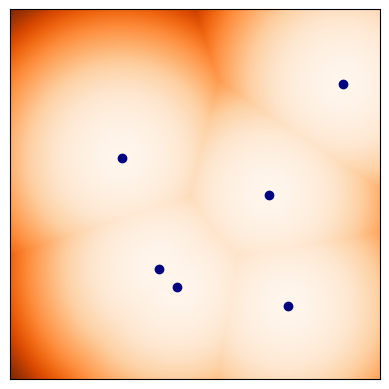

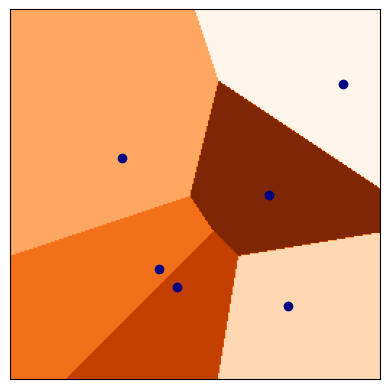

In [ ]:
v = torch.zeros(n).to(device)

# c-transform
psix,index = ctransform(xgrid,y,v)

fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(psix.cpu().numpy().reshape(nr,nc),cmap = 'Oranges', extent=extent)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

# Laguerre diagram
Tx,cx = transport_and_color(xgrid,y,v.detach())
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(cx.cpu().numpy().reshape(nr,nc),cmap = 'Oranges', extent=extent)
plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
plt.show()

## Plot optimal c-transform for fixed generator

QUESTION: Complete the following code at the blocks ###...###.

The dual variable `v` should be optimized in order to approximate the solution of semi-discrete optimal transport.

[100/1000], -21.540871


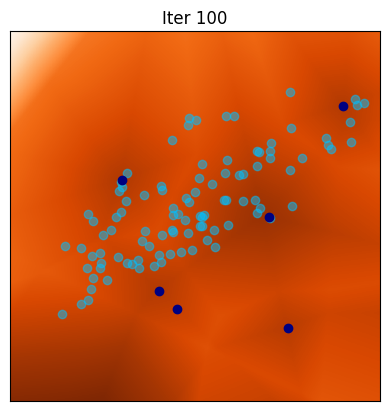

[200/1000], -40.764721


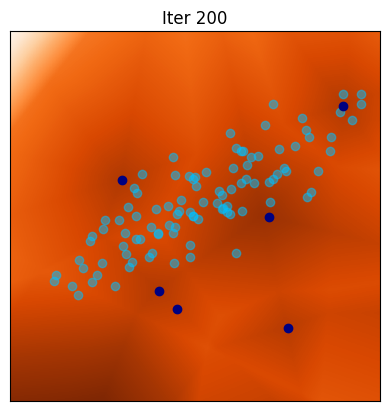

[300/1000], -60.076378


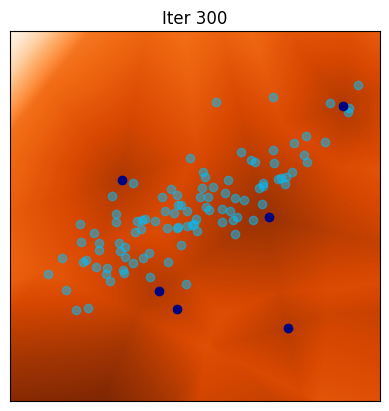

[400/1000], -79.536522


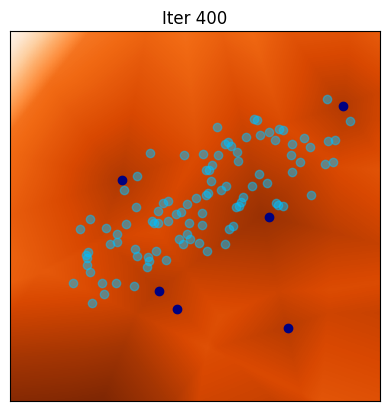

[500/1000], -98.397415


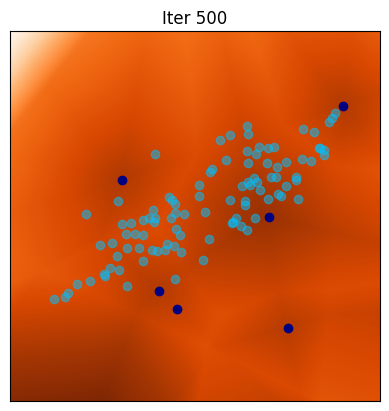

[600/1000], -117.646729


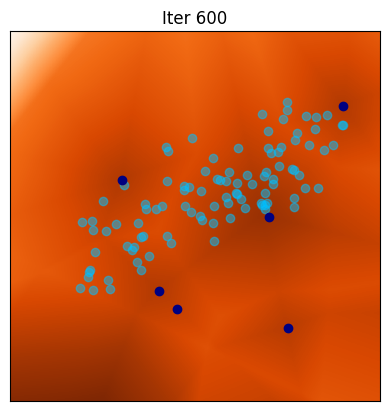

[700/1000], -137.250839


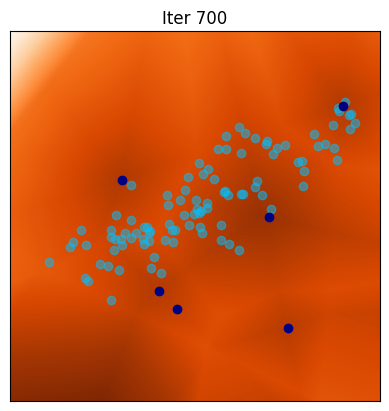

[800/1000], -156.319138


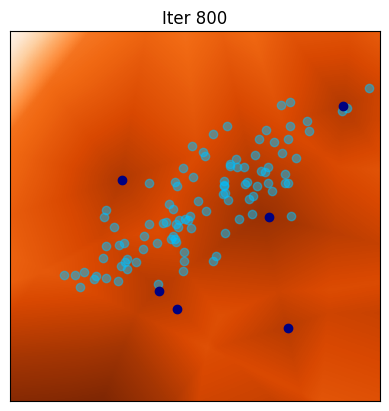

[900/1000], -175.548950


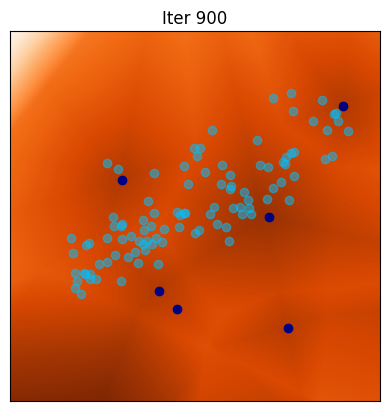

In [ ]:
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

v = torch.zeros(n, device=device, requires_grad=True)
optimD = optim.Adam([v], lr=lrdisc, betas=(beta_1, beta_2)) #Ce n'est pas un discriminateur ici
# optimD = optim.ASGD([v], lr=lrdisc, alpha=.5)
niterD=1000
Dlosses = []
nu = torch.ones(n,dtype = torch.float)*1/n
iter_display = 100

for iter in range(1,niterD):
  optimD.zero_grad()
  z = torch.randn((b, n_in))
  x = G(z)
  Dloss = -lossdisc(x.detach(),y,v,nu)
  Dloss.backward()
  optimD.step()

  ### SAVE LOSS ###
  Dlosst = Dloss.item()
  Dlosses.append(-Dlosst)
  if(iter%iter_display == 0):
      print('[%d/%d], %f' % (iter, niterD, Dlosst))
      x = G(z)
      xd = x.detach().squeeze(1)
      strtitle = 'Iter '+str(iter)
      fig = plt.figure(dpi=100)
      plt.xticks([])

      plt.yticks([])
      plt.imshow(psix.cpu().numpy().reshape(nr,nc),cmap = 'Oranges', extent=extent)
      plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
      plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
      plt.title(strtitle)
      plt.show()

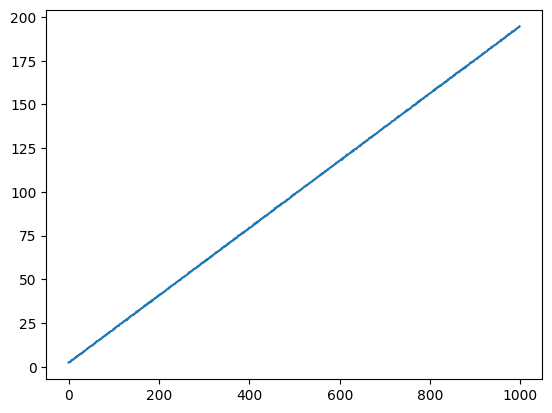

In [ ]:
### Plot discriminator loss ###
plt.plot(Dlosses)

## Train both the Generator and Discriminator

In this question, we will train the generator in order to optimize a WGAN with the semi-discrete formulation (involving the c-transform).

QUESTION: Complete the following code at the blocks ###...###.

[1/100] 	Loss_D: -194.6191	Loss_G: 194.3677
[2/100] 	Loss_D: -386.4826	Loss_G: 386.2328
[3/100] 	Loss_D: -578.7793	Loss_G: 578.5563
[4/100] 	Loss_D: -770.9947	Loss_G: 771.0639
[5/100] 	Loss_D: -964.0339	Loss_G: 963.7999
[6/100] 	Loss_D: -1156.2812	Loss_G: 1156.3318
[7/100] 	Loss_D: -1348.9161	Loss_G: 1348.7054
[8/100] 	Loss_D: -1541.5674	Loss_G: 1541.5697
[9/100] 	Loss_D: -1733.9780	Loss_G: 1733.7118
[10/100] 	Loss_D: -1926.7302	Loss_G: 1926.3699


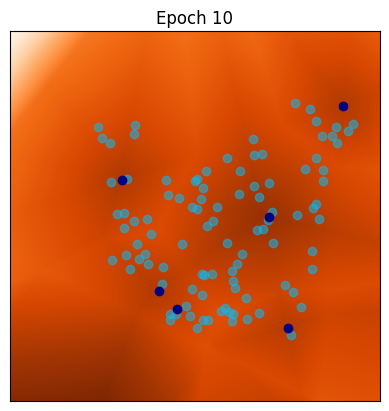

[11/100] 	Loss_D: -2119.3916	Loss_G: 2119.1499
[12/100] 	Loss_D: -2312.0500	Loss_G: 2312.1184
[13/100] 	Loss_D: -2504.5020	Loss_G: 2504.3535
[14/100] 	Loss_D: -2696.9368	Loss_G: 2697.1426
[15/100] 	Loss_D: -2889.4607	Loss_G: 2889.4961
[16/100] 	Loss_D: -3082.0962	Loss_G: 3082.2888
[17/100] 	Loss_D: -3274.7937	Loss_G: 3275.0476
[18/100] 	Loss_D: -3467.5227	Loss_G: 3467.4995
[19/100] 	Loss_D: -3659.7444	Loss_G: 3659.8767
[20/100] 	Loss_D: -3852.5781	Loss_G: 3852.8230


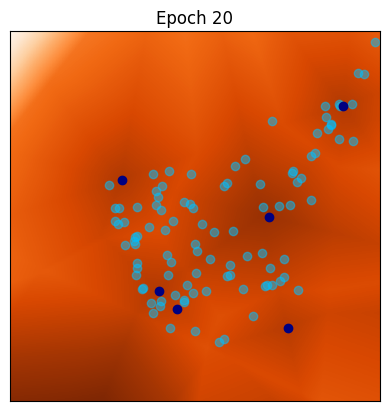

[21/100] 	Loss_D: -4045.2747	Loss_G: 4045.0471
[22/100] 	Loss_D: -4237.7437	Loss_G: 4237.7388
[23/100] 	Loss_D: -4430.4917	Loss_G: 4430.1226
[24/100] 	Loss_D: -4622.6675	Loss_G: 4623.1450
[25/100] 	Loss_D: -4815.7485	Loss_G: 4815.6514
[26/100] 	Loss_D: -5008.4639	Loss_G: 5008.0762
[27/100] 	Loss_D: -5200.9673	Loss_G: 5201.0522
[28/100] 	Loss_D: -5393.7070	Loss_G: 5393.7197
[29/100] 	Loss_D: -5586.0000	Loss_G: 5586.2935
[30/100] 	Loss_D: -5778.9526	Loss_G: 5778.9927


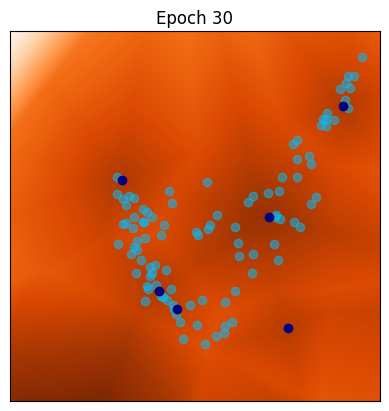

[31/100] 	Loss_D: -5971.5737	Loss_G: 5971.6968
[32/100] 	Loss_D: -6164.3579	Loss_G: 6164.5137
[33/100] 	Loss_D: -6357.0996	Loss_G: 6357.1274
[34/100] 	Loss_D: -6549.8931	Loss_G: 6549.8311
[35/100] 	Loss_D: -6742.6523	Loss_G: 6742.5952
[36/100] 	Loss_D: -6934.9956	Loss_G: 6935.1958
[37/100] 	Loss_D: -7127.9453	Loss_G: 7127.9917
[38/100] 	Loss_D: -7320.5098	Loss_G: 7320.9419
[39/100] 	Loss_D: -7513.3867	Loss_G: 7513.5273
[40/100] 	Loss_D: -7706.2437	Loss_G: 7706.2354


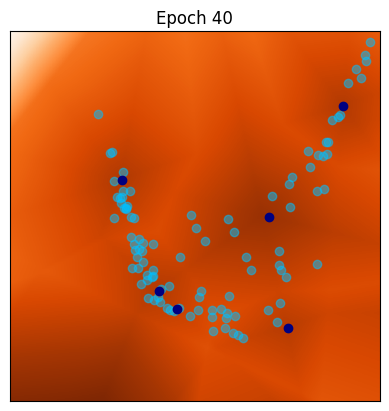

[41/100] 	Loss_D: -7898.8438	Loss_G: 7899.2197
[42/100] 	Loss_D: -8091.8413	Loss_G: 8091.9512
[43/100] 	Loss_D: -8284.6963	Loss_G: 8285.0205
[44/100] 	Loss_D: -8477.3701	Loss_G: 8477.4844
[45/100] 	Loss_D: -8670.2256	Loss_G: 8670.3984
[46/100] 	Loss_D: -8863.1680	Loss_G: 8863.3936
[47/100] 	Loss_D: -9055.7021	Loss_G: 9056.1973
[48/100] 	Loss_D: -9248.6250	Loss_G: 9248.8545
[49/100] 	Loss_D: -9441.5186	Loss_G: 9441.4209
[50/100] 	Loss_D: -9634.0615	Loss_G: 9634.2246


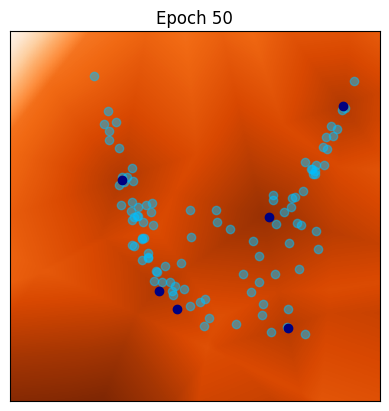

[51/100] 	Loss_D: -9827.5684	Loss_G: 9826.6934
[52/100] 	Loss_D: -10019.3926	Loss_G: 10019.9844
[53/100] 	Loss_D: -10212.4854	Loss_G: 10212.3018
[54/100] 	Loss_D: -10405.2402	Loss_G: 10405.3555
[55/100] 	Loss_D: -10597.7734	Loss_G: 10597.9199
[56/100] 	Loss_D: -10790.7344	Loss_G: 10790.6807
[57/100] 	Loss_D: -10983.3047	Loss_G: 10983.6035
[58/100] 	Loss_D: -11176.0645	Loss_G: 11175.8867
[59/100] 	Loss_D: -11368.6191	Loss_G: 11368.9082
[60/100] 	Loss_D: -11561.6104	Loss_G: 11561.5146


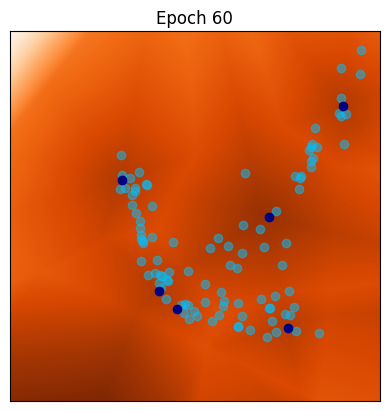

[61/100] 	Loss_D: -11754.5625	Loss_G: 11754.5205
[62/100] 	Loss_D: -11947.1230	Loss_G: 11947.4102
[63/100] 	Loss_D: -12139.8730	Loss_G: 12139.9980
[64/100] 	Loss_D: -12332.4688	Loss_G: 12332.4121
[65/100] 	Loss_D: -12525.3076	Loss_G: 12523.7852
[66/100] 	Loss_D: -12717.4795	Loss_G: 12717.8066
[67/100] 	Loss_D: -12910.3418	Loss_G: 12910.4170
[68/100] 	Loss_D: -13103.2334	Loss_G: 13102.9170
[69/100] 	Loss_D: -13295.9766	Loss_G: 13295.4551
[70/100] 	Loss_D: -13488.0479	Loss_G: 13488.5400


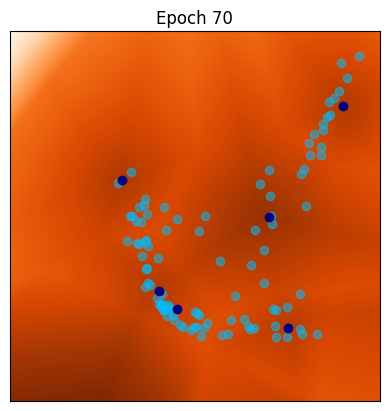

[71/100] 	Loss_D: -13681.0107	Loss_G: 13681.3311
[72/100] 	Loss_D: -13873.7930	Loss_G: 13873.6963
[73/100] 	Loss_D: -14066.5947	Loss_G: 14066.3975
[74/100] 	Loss_D: -14259.0430	Loss_G: 14259.4658
[75/100] 	Loss_D: -14452.0537	Loss_G: 14451.8301
[76/100] 	Loss_D: -14644.4238	Loss_G: 14644.6816
[77/100] 	Loss_D: -14837.2471	Loss_G: 14837.4229
[78/100] 	Loss_D: -15029.9746	Loss_G: 15030.1016
[79/100] 	Loss_D: -15222.8789	Loss_G: 15222.8711
[80/100] 	Loss_D: -15415.4326	Loss_G: 15415.7705


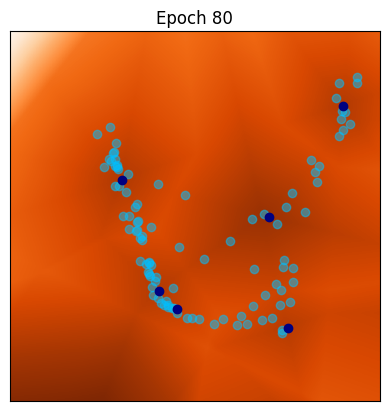

[81/100] 	Loss_D: -15607.9834	Loss_G: 15608.2158
[82/100] 	Loss_D: -15800.9648	Loss_G: 15801.2598
[83/100] 	Loss_D: -15993.9395	Loss_G: 15993.8213
[84/100] 	Loss_D: -16186.2627	Loss_G: 16186.7402
[85/100] 	Loss_D: -16379.1924	Loss_G: 16379.2861
[86/100] 	Loss_D: -16571.6777	Loss_G: 16571.7246
[87/100] 	Loss_D: -16764.6543	Loss_G: 16764.6660
[88/100] 	Loss_D: -16957.0898	Loss_G: 16957.6387
[89/100] 	Loss_D: -17150.3086	Loss_G: 17150.1562
[90/100] 	Loss_D: -17342.7617	Loss_G: 17342.9297


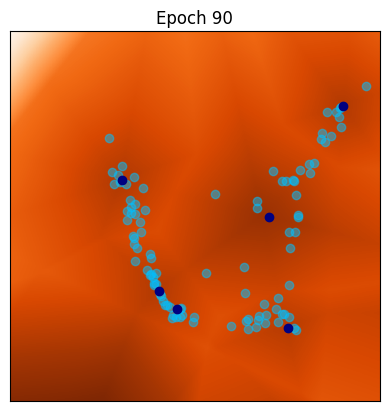

[91/100] 	Loss_D: -17535.5527	Loss_G: 17535.8672
[92/100] 	Loss_D: -17728.2461	Loss_G: 17728.6504
[93/100] 	Loss_D: -17921.0352	Loss_G: 17921.3848
[94/100] 	Loss_D: -18114.0586	Loss_G: 18114.1738
[95/100] 	Loss_D: -18306.7910	Loss_G: 18307.0430
[96/100] 	Loss_D: -18499.4219	Loss_G: 18499.5449
[97/100] 	Loss_D: -18692.3398	Loss_G: 18692.3652
[98/100] 	Loss_D: -18884.8535	Loss_G: 18885.0293
[99/100] 	Loss_D: -19077.5801	Loss_G: 19077.6914


<All keys matched successfully>

In [ ]:
lr = 0.002   # learning rate for generator

## parameters for training
n_epochs = 100
niterD=1000
niterG=10

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

v = torch.zeros(n, device=device, requires_grad=True)
optimD = optim.Adam([v], lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(1,n_epochs):
  #Discriminator step
  for iter in range(1,niterD):
    optimD.zero_grad()
    z = torch.randn((b, n_in))
    x = G(z)
    Dloss = -lossdisc(x.detach(),y,v,nu) #Try to find the right v
    Dloss.backward()
    optimD.step()

  #Generator step
  for iter in range(0,niterG):
    optimG.zero_grad()
    z = torch.randn((b, n_in))
    x = G(z)
    Dx = D(x)
    Gloss = lossdisc(x,y,v,nu)
    Gloss.backward()
    optimG.step()

    # Output training stats
  print('[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f'
    % (epoch, n_epochs, Dloss.item(), Gloss.item()))
  Glosses.append(Gloss.item())
  if(epoch % iter_display == 0):
      z = torch.randn(b, 1, n_in, device=device) #noise
      x = G(z)
      xd = x.detach().squeeze(1)
      strtitle = 'Epoch '+str(epoch)
      fig = plt.figure(dpi=100)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(psix.cpu().numpy().reshape(nr,nc),cmap = 'Oranges', extent=extent)
      plt.scatter(xd[:, 0].cpu(), xd[:,1].cpu(),c='deepskyblue',alpha=.5)
      plt.scatter(y[:, 0].cpu(), y[:,1].cpu(),c='navy')
      plt.title(strtitle)
      plt.show()
    # (adapt the loop from WGAN-GP)

# Save final generator for later use
wgansd = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgansd.load_state_dict(G.state_dict())

## Train the generator only

QUESTION: For a fixed discriminator, optimize the generator only. Can you explain what is happening then?

In [ ]:
### ... ###

<br/><br/><br/><br/>

# Exercise 4: The Impact of Parameters

The goal of this final exercise is to study the impact of parameters in the GAN/WGAN learning strategy. You may copy parts of code written, and adapt some parts to answer the following questions.

QUESTION: Examine the impact of the parameters of the optimizers (learning rate, ADAM $\beta$ parameters) in the learning process of the generative model.

QUESTION: Examine the impact of the min-max optimization strategy (number of updates of $D$ or $G$ per epoch)  in the learning process of the generative model.

QUESTION:

The semi-discrete formulation of WGAN allows to use general cost functions.

Try and compare semi-discrete learning with $p=1$ or $p=2$ (or even other values).